In [1]:
import os
import glob # For finding files
import random
import librosa
import librosa.display
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # To suppress warnings from librosa or other libraries

In [2]:
# Audio Preprocessing Functions
def remove_silence(y, sr, top_db=20):
    """
    Remove silence from the beginning and end of the audio.
    A higher top_db will trim more aggressively.
    """
    yt, index = librosa.effects.trim(y, top_db=top_db)
    # print(f"Original length: {len(y)}, Trimmed length: {len(yt)}")
    if len(yt) == 0: # if trimming removed everything, return original with a warning
        # print("Warning: Trimming removed entire audio. Returning original.")
        return y
    return yt

def bandpass_filter(data, sr, lowcut=300.0, highcut=3400.0, order=5):
    """
    Apply a bandpass filter to the audio data.
    Focuses on the typical human voice frequency range.
    """
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    if low >= 1.0: low = 0.99 # Ensure low is < 1.0
    if high >= 1.0: high = 0.99 # Ensure high is < 1.0
    if low >= high: # Ensure low < high
        # print(f"Warning: lowcut {lowcut}Hz >= highcut {highcut}Hz. Adjusting lowcut.")
        low = high / 2 
        if low == 0 : low = 0.01 # ensure low is not zero

    try:
        b, a = butter(order, [low, high], btype='band')
        y = lfilter(b, a, data)
        return y
    except Exception as e:
        # print(f"Error in bandpass filter: {e}. Returning original data.")
        return data


def normalize_volume(y, desired_rms=0.05):
    """
    Normalize the volume of the audio signal to a desired RMS level.
    """
    current_rms = np.sqrt(np.mean(y**2))
    if current_rms == 0: # Avoid division by zero for silent audio
        return y
    y_normalized = y * (desired_rms / current_rms)
    return y_normalized

# Feature Extraction Function
def extract_features(y, sr, n_mfcc=13, n_mels=128, hop_length=512, frame_length=2048):
    """
    Extracts a dictionary of features from an audio signal.
    """
    features = {}

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=frame_length, hop_length=hop_length)
    for i in range(n_mfcc):
        features[f'mfcc_mean_{i}'] = np.mean(mfccs[i,:])
        features[f'mfcc_std_{i}'] = np.std(mfccs[i,:])
        features[f'mfcc_median_{i}'] = np.median(mfccs[i,:]) # Adding median

    # Chroma Features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length)
    for i in range(chroma.shape[0]):
        features[f'chroma_mean_{i}'] = np.mean(chroma[i,:])
        features[f'chroma_std_{i}'] = np.std(chroma[i,:])

    # Spectral Contrast
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length)
    for i in range(spec_contrast.shape[0]):
        features[f'spec_contrast_mean_{i}'] = np.mean(spec_contrast[i,:])
        features[f'spec_contrast_std_{i}'] = np.std(spec_contrast[i,:])

    # Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length)
    features['zcr_mean'] = np.mean(zcr)
    features['zcr_std'] = np.std(zcr)
    features['zcr_median'] = np.median(zcr) # Adding median

    # RMS Energy
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)
    features['rms_mean'] = np.mean(rms)
    features['rms_std'] = np.std(rms)
    features['rms_median'] = np.median(rms) # Adding median
    
    # Mel Spectrogram features (mean and std per mel band)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    # Reduce the number of mel band features to avoid too high dimensionality
    # For example, take mean/std over first few and last few bands, or overall mean/std
    features['mel_spec_db_mean_overall'] = np.mean(mel_spec_db)
    features['mel_spec_db_std_overall'] = np.std(mel_spec_db)
    # Alternatively, average across frequency bands for each time frame, then take stats
    # mean_mel_spec_db_per_frame = np.mean(mel_spec_db, axis=0)
    # features['mel_spec_db_temporal_mean'] = np.mean(mean_mel_spec_db_per_frame)
    # features['mel_spec_db_temporal_std'] = np.std(mean_mel_spec_db_per_frame)


    # Tonnetz (Tonal Centroid Features)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    for i in range(tonnetz.shape[0]):
        features[f'tonnetz_mean_{i}'] = np.mean(tonnetz[i,:])
        features[f'tonnetz_std_{i}'] = np.std(tonnetz[i,:])

    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length)
    features['spectral_centroid_mean'] = np.mean(spectral_centroid)
    features['spectral_centroid_std'] = np.std(spectral_centroid)

    # Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length)
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)
    
    # Spectral Rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length)
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
    features['spectral_rolloff_std'] = np.std(spectral_rolloff)

    return features

In [3]:
import os
import glob
import random
import librosa
import numpy as np
import pandas as pd
# Make sure your audio processing functions (remove_silence, bandpass_filter, normalize_volume)
# and extract_features function are defined in a previous cell (e.g., Cell 2).

def process_audio_files(real_voice_dir, list_of_fake_voice_dirs, output_csv,
                        num_real_samples_to_select=1000,
                        total_fake_samples_to_select=1000):
    """
    Processes audio files: num_real_samples_to_select real voices and
    total_fake_samples_to_select fake voices (distributed among list_of_fake_voice_dirs).
    Extracts features and saves them to a CSV file.
    """
    all_selected_files_with_labels = []

    # 1. Collect and select REAL voice files
    real_files_found = glob.glob(os.path.join(real_voice_dir, '**', '*.wav'), recursive=True) + \
                       glob.glob(os.path.join(real_voice_dir, '*.wav'))
    real_files_found = list(set(real_files_found)) # Remove duplicates
    print(f"Found {len(real_files_found)} real voice files in {real_voice_dir}.")

    if len(real_files_found) == 0:
        print(f"Warning: No real voice files found in {real_voice_dir}. Cannot proceed.")
        return None
    
    num_real_to_sample = min(num_real_samples_to_select, len(real_files_found))
    selected_real_files = random.sample(real_files_found, num_real_to_sample)
    for file_path in selected_real_files:
        all_selected_files_with_labels.append((file_path, 1)) # Label 1 for real
    print(f"Selected {len(selected_real_files)} real voice files.")

    # 2. Collect and select FAKE voice files
    num_fake_types = len(list_of_fake_voice_dirs)
    if num_fake_types == 0:
        print("Warning: No fake voice directories provided.")
        # Decide if you want to proceed with only real voices or stop
    
    base_samples_per_type = total_fake_samples_to_select // num_fake_types if num_fake_types > 0 else 0
    remainder_samples = total_fake_samples_to_select % num_fake_types if num_fake_types > 0 else 0
    
    actual_fake_samples_collected = 0
    for i, fake_dir in enumerate(list_of_fake_voice_dirs):
        fake_files_in_dir = glob.glob(os.path.join(fake_dir, '**', '*.wav'), recursive=True) + \
                              glob.glob(os.path.join(fake_dir, '*.wav'))
        fake_files_in_dir = list(set(fake_files_in_dir))
        print(f"Found {len(fake_files_in_dir)} fake voice files in {fake_dir}.")

        if not fake_files_in_dir:
            print(f"Warning: No files found in fake directory {fake_dir}. Skipping.")
            continue

        num_to_sample_from_this_type = base_samples_per_type
        if i < remainder_samples:
            num_to_sample_from_this_type += 1
        
        num_to_sample_from_this_type = min(num_to_sample_from_this_type, len(fake_files_in_dir))
        
        selected_fake_files_from_type = random.sample(fake_files_in_dir, num_to_sample_from_this_type)
        for file_path in selected_fake_files_from_type:
            all_selected_files_with_labels.append((file_path, 0)) # Label 0 for fake
        actual_fake_samples_collected += len(selected_fake_files_from_type)
        print(f"Selected {len(selected_fake_files_from_type)} fake voice files from {fake_dir}.")
    
    print(f"Total selected fake voice files: {actual_fake_samples_collected}")
    print(f"Total selected files for processing: {len(all_selected_files_with_labels)}")

    if not all_selected_files_with_labels:
        print("No audio files selected for processing. Please check the directories and sampling logic.")
        return None

    random.shuffle(all_selected_files_with_labels) # Shuffle combined list

    features_list = []
    processed_count = 0
    total_to_process = len(all_selected_files_with_labels)

    for file_path, label in all_selected_files_with_labels:
        try:
            y, sr = librosa.load(file_path, sr=None)
            if len(y) == 0:
                # print(f"Warning: Empty audio file {file_path}. Skipping.")
                continue

            # Apply previously defined preprocessing functions
            y = remove_silence(y, sr, top_db=25)
            if len(y) == 0:
                # print(f"Warning: Audio empty after silence removal for {file_path}. Skipping.")
                continue
            y = bandpass_filter(y, sr, lowcut=200.0, highcut=4000.0, order=4)
            y = normalize_volume(y, desired_rms=0.05)

            # Apply previously defined feature extraction
            features = extract_features(y, sr) # Ensure extract_features is defined
            features['label'] = label

            features_list.append(features)
            processed_count += 1
            if processed_count % 100 == 0 or processed_count == total_to_process:
                 print(f"Processed {processed_count}/{total_to_process} files...")

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    if not features_list:
        print("No features extracted. Check processing logic or input files.")
        return None
        
    df = pd.DataFrame(features_list)
    df.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}. Shape: {df.shape}")
    return df

In [4]:
# Define paths
BASE_DATA_PATH = '/kaggle/input/librisevoc/LibriSeVoc'
REAL_VOICE_DIR = os.path.join(BASE_DATA_PATH, 'gt')

FAKE_VOICE_TYPES = [
    'diffwave',
    'melgan',
    'parallel_wave_gan',
    'wavegrad',
    'wavenet',
    'wavernn'
]
FAKE_VOICE_DIRS = [os.path.join(BASE_DATA_PATH, ftype) for ftype in FAKE_VOICE_TYPES]

# Output CSV filename - consider changing if you want to keep previous results
OUTPUT_CSV = 'audio_features_real_vs_6fake.csv'

# Parameters for sampling
NUM_REAL_SAMPLES = 13171
TOTAL_FAKE_SAMPLES = 13171 # To be divided among the 6 types

# Process the audio files
print("Starting audio processing...")
df_features = process_audio_files(REAL_VOICE_DIR, FAKE_VOICE_DIRS, OUTPUT_CSV,
                                  num_real_samples_to_select=NUM_REAL_SAMPLES,
                                  total_fake_samples_to_select=TOTAL_FAKE_SAMPLES)

if df_features is not None:
    print("\nFeature extraction process complete.")
    print("Preview of the first 5 rows of the_features dataframe:")
    print(df_features.head())
    if 'label' in df_features.columns:
        print(f"\nValue counts for 'label' in the generated CSV:\n{df_features['label'].value_counts()}")
    else:
        print("\nWarning: 'label' column not found in the resulting DataFrame.")
else:
    print("\nFeature extraction failed or produced no data.")

Starting audio processing...
Found 13201 real voice files in /kaggle/input/librisevoc/LibriSeVoc/gt.
Selected 13171 real voice files.
Found 13201 fake voice files in /kaggle/input/librisevoc/LibriSeVoc/diffwave.
Selected 2196 fake voice files from /kaggle/input/librisevoc/LibriSeVoc/diffwave.
Found 13201 fake voice files in /kaggle/input/librisevoc/LibriSeVoc/melgan.
Selected 2195 fake voice files from /kaggle/input/librisevoc/LibriSeVoc/melgan.
Found 13201 fake voice files in /kaggle/input/librisevoc/LibriSeVoc/parallel_wave_gan.
Selected 2195 fake voice files from /kaggle/input/librisevoc/LibriSeVoc/parallel_wave_gan.
Found 13201 fake voice files in /kaggle/input/librisevoc/LibriSeVoc/wavegrad.
Selected 2195 fake voice files from /kaggle/input/librisevoc/LibriSeVoc/wavegrad.
Found 13201 fake voice files in /kaggle/input/librisevoc/LibriSeVoc/wavenet.
Selected 2195 fake voice files from /kaggle/input/librisevoc/LibriSeVoc/wavenet.
Found 13201 fake voice files in /kaggle/input/librisev

In [5]:
if os.path.exists(OUTPUT_CSV):
    data = pd.read_csv(OUTPUT_CSV)
    print(f"Loaded data from {OUTPUT_CSV}. Shape: {data.shape}")

    # Handle potential NaN values (e.g., from very short audio files or errors)
    # Option 1: Fill with mean (careful if many NaNs)
    # data = data.fillna(data.mean()) 
    # Option 2: Drop rows with NaNs (if few)
    data.dropna(inplace=True)
    print(f"Shape after dropping NaNs: {data.shape}")


    if 'label' not in data.columns:
        print("Error: 'label' column not found in the CSV.")
    elif data.empty:
        print("Error: Data is empty after loading/cleaning.")
    else:
        X = data.drop('label', axis=1)
        y = data['label']

        print(f"Features shape (X): {X.shape}")
        print(f"Labels shape (y): {y.shape}")
        print(f"\nClass distribution in y:\n{y.value_counts(normalize=True)}")


        # Ensure all feature columns are numeric
        X = X.apply(pd.to_numeric, errors='coerce')
        X.dropna(axis=1, how='all', inplace=True) # Drop columns that are all NaN
        X.fillna(X.mean(), inplace=True) # Fill any remaining NaNs

        if X.empty:
            print("Error: Feature set X is empty after numeric conversion and NaN handling.")
        else:
            # Split data
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

            print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
            print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

            # Scale features (important for many ML models, can help XGBoost too)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Convert scaled arrays back to DataFrame (optional, but can be convenient)
            X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
            X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

            print("\nData preparation for modeling complete.")
else:
    print(f"Error: {OUTPUT_CSV} not found. Run the previous cell to generate it.")

Loaded data from audio_features_real_vs_6fake.csv. Shape: (26342, 104)
Shape after dropping NaNs: (26342, 104)
Features shape (X): (26342, 103)
Labels shape (y): (26342,)

Class distribution in y:
label
1    0.5
0    0.5
Name: proportion, dtype: float64
X_train shape: (21073, 103), y_train shape: (21073,)
X_test shape: (5269, 103), y_test shape: (5269,)

Data preparation for modeling complete.


In [6]:
if 'X_train' in locals() and 'y_train' in locals():
    model = xgb.XGBClassifier(
        objective='binary:logistic', # for binary classification
        eval_metric='logloss',       # evaluation metric
        use_label_encoder=False,     # Suppress UserWarning about LabelEncoder
        n_estimators=200,            # Number of trees
        learning_rate=0.1,           # Learning rate
        max_depth=5,                 # Maximum depth of a tree
        subsample=0.8,               # Subsample ratio of the training instance
        colsample_bytree=0.8,        # Subsample ratio of columns when constructing each tree
        random_state=42,
        n_jobs=-1                    # Use all available CPU cores
    )

    print("Training XGBoost model...")
    model.fit(X_train, y_train,
              early_stopping_rounds=20, # Stop if no improvement after 20 rounds
              eval_set=[(X_test, y_test)],
              verbose=False) # Set to True or a number to see training progress

    print("XGBoost model training complete.")
else:
    print("Training data (X_train, y_train) not available. Please run previous cells.")

Training XGBoost model...
XGBoost model training complete.



Evaluating model...
Accuracy: 0.8632

Classification Report:
              precision    recall  f1-score   support

    Fake (0)       0.87      0.85      0.86      2635
    Real (1)       0.85      0.88      0.87      2634

    accuracy                           0.86      5269
   macro avg       0.86      0.86      0.86      5269
weighted avg       0.86      0.86      0.86      5269


Confusion Matrix:
[[2238  397]
 [ 324 2310]]


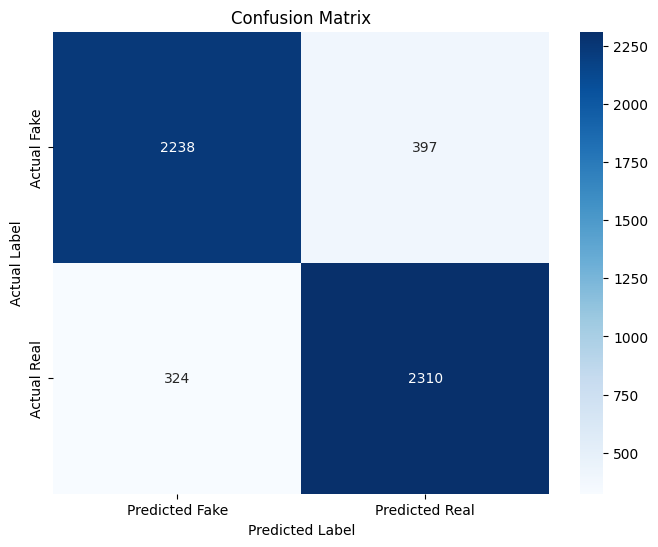

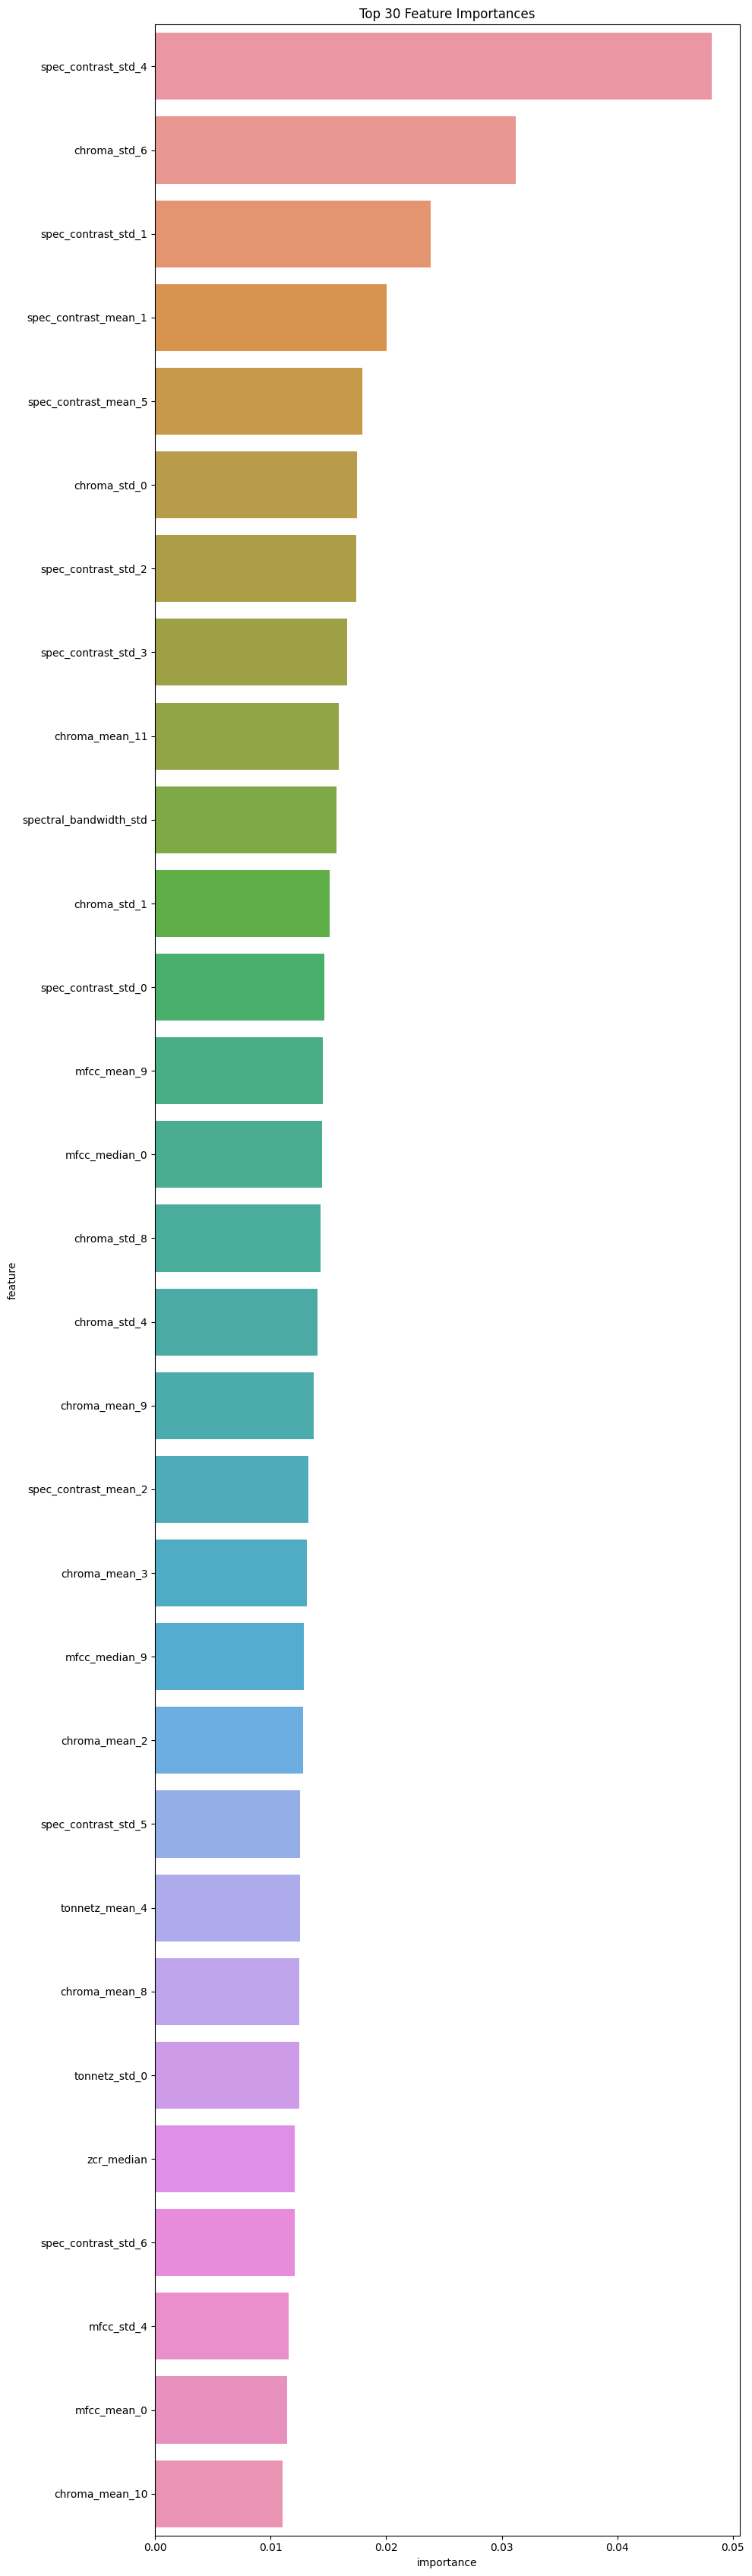

In [7]:
if 'model' in locals() and 'X_test' in locals() and 'y_test' in locals():
    print("\nEvaluating model...")
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilities for the positive class
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Classification Report
    print("\nClassification Report:")
    # Ensure target_names correspond to your labels (0: Fake, 1: Real)
    print(classification_report(y_test, y_pred, target_names=['Fake (0)', 'Real (1)']))

    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Plotting Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Fake', 'Predicted Real'], 
                yticklabels=['Actual Fake', 'Actual Real'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Importance (optional, but insightful)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X_train.columns
        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

        plt.figure(figsize=(10, max(10, len(feature_names) // 3))) # Adjust size
        sns.barplot(x='importance', y='feature', data=feature_importance_df.head(30)) # Display top 30
        plt.title('Top 30 Feature Importances')
        plt.tight_layout()
        plt.show()

else:
    print("Model or test data not available for evaluation. Please run previous cells.")